## Описание проекта

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

# Подготовка

In [ ]:
# Загрузили необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import catboost
from catboost import CatBoostRegressor
import lightgbm
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


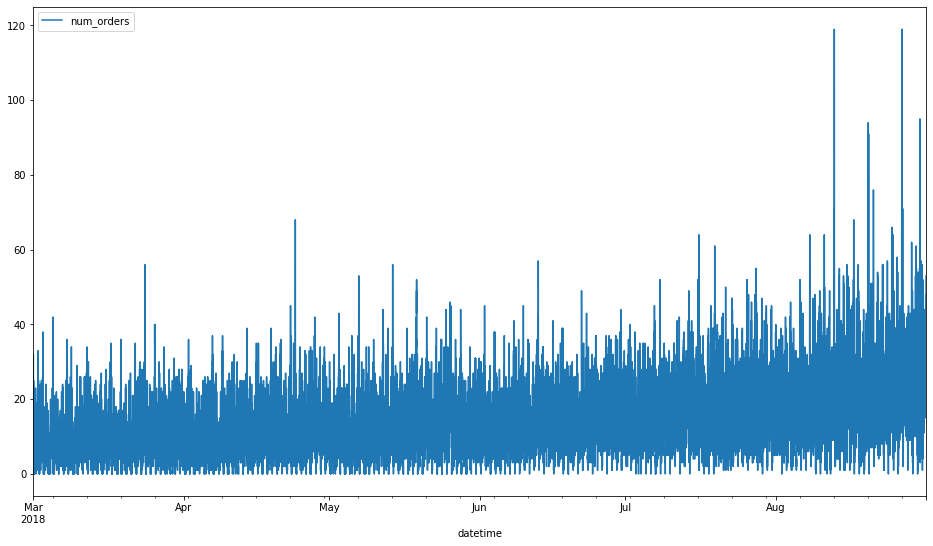

In [ ]:
# Загрузили данные, проверили сортировку 
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(df.head())
df.sort_index(inplace=True)
display(df.index.is_monotonic)
df.info()
df.plot(figsize=(16,9))

**Выводы**
- Данные разбиты по 10 минут;
- Сортировка не нарушена;
- Необходимо посмотреть распределение и наличие пропусков и прочего шума.

In [ ]:
df.describe()
# распределение нормальное, медиана и среднее близки, ср.кв.отклонение имеет среднее значение по причине выбросов.
# Но трогать выбросы нельзя, это временной ряд.

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


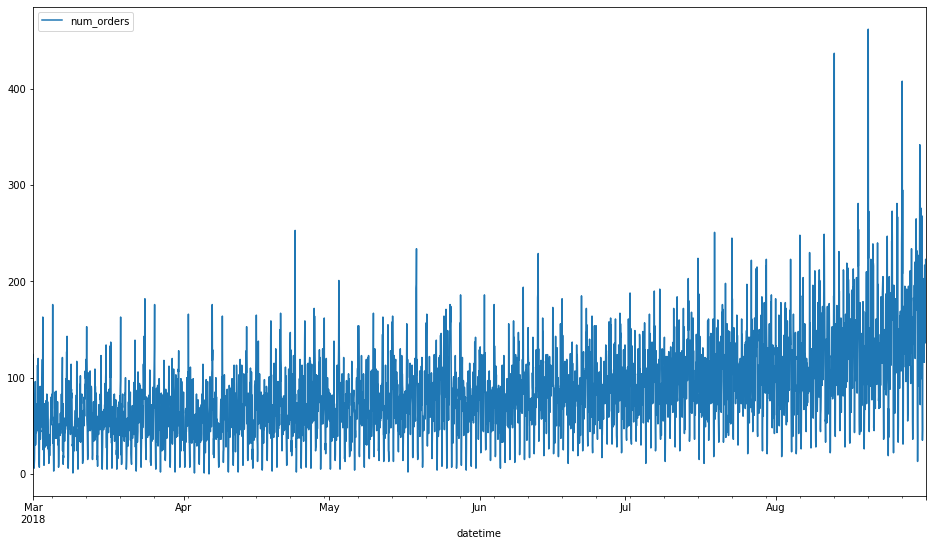

In [ ]:
df = df.resample('1H').sum()
df.plot(figsize=(16,9))
# Провели ресемплирование, основные значения идут до 200, выше 200-250 есть значения, но их не много и в основном в августе.
# Вероятно, август для этого региона является туристическим.

In [ ]:
# Препроцессинг
# NaN
df[df['num_orders'].isna()]

,num_orders
datetime,


In [ ]:
# Скачков в показателя немного
display(df[df['num_orders'] == 0])
display(df[df['num_orders'] > 200])

,num_orders
datetime,
2018-04-06 06:00:00,0


,num_orders
datetime,
2018-04-24 00:00:00,253
2018-05-03 00:00:00,201
2018-05-19 00:00:00,234
2018-06-13 02:00:00,229
2018-07-14 00:00:00,203
...,...
2018-08-31 09:00:00,203
2018-08-31 17:00:00,217
2018-08-31 18:00:00,207


# Анализ

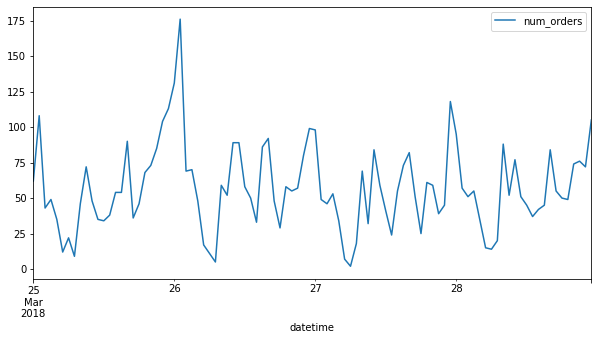

In [ ]:
# Проанализируем графики 
df['2018-03-25':'2018-03-28'].plot(figsize=(10,5))

**Вывод**
- Можем увидеть на графике некоторую зависимость от времени суток, максимально в 12 и час ночи, минимально, к утру.

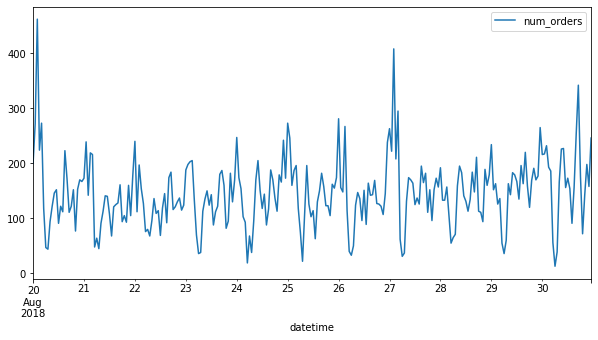

In [ ]:
df['2018-08-20':'2018-08-30'].plot(figsize=(10,5))

In [ ]:
# Проанализируем тренд и сезонность
decomposed = seasonal_decompose(df)

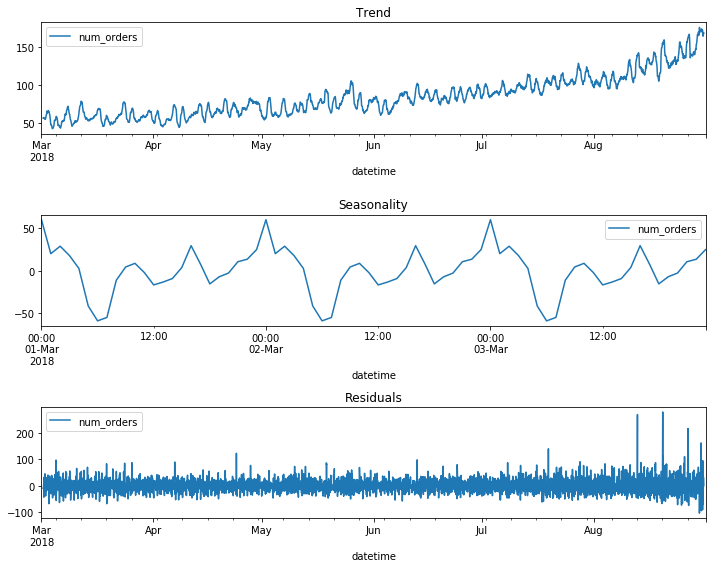

In [ ]:
plt.figure(figsize=(10, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод**
- Есть тренд, который зарождается с середины апреля, а в августе растет по экспоненте, основная масса туристов хлынула именно в это время.
- Прослеживается сезонность внутри дня, 6 часов - минимальное кол-во заявок, 00.00 - максимальное; с 6 до 00.00 - рост заявок, с 00.00 до 6 резкое падение.

# Обучение

In [ ]:
df_1 = df.copy()

In [ ]:
# Обработаем таблицу с помощью функции, добавим lag & rolling_mean
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
# Пименим функцию
make_features(df_1, 24, 5)
# Посмотрим новый датасет
df_1

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,19,207.0,217.0,197.0,116.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,174.0
2018-08-31 20:00:00,154,2018,8,31,4,20,136.0,207.0,217.0,197.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,174.6
2018-08-31 21:00:00,159,2018,8,31,4,21,154.0,136.0,207.0,217.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,182.2


In [ ]:
# Выделим тестовую выборку
train, test = train_test_split(df_1, shuffle=False, test_size=0.1)
# Уберем возникшие Nan
train = train.dropna()
train, val = train_test_split(train, shuffle=False, test_size=0.2)

In [ ]:
# Константная модель
print("Средний объём заказов в час:", val['num_orders'].mean())
pred_median = (np.ones(val.shape[0]) * train['num_orders'].median())
print("RMSE:", mean_squared_error(val['num_orders'], pred_median)**0.5)

Средний объём заказов в час: 106.50379746835443
RMSE: 56.637354046757174


In [ ]:
# Выделим целевой признак
X_tr = train.drop('num_orders', axis=1)
y_tr = train['num_orders']
X_v = val.drop('num_orders', axis=1)
y_v = val['num_orders']
X_t = test.drop('num_orders', axis=1)
y_t = test['num_orders']

In [ ]:
# Прверим предсказание линейной регрессии
lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_pred = lr.predict(X_v)
print('Результат линейной регрессии RMSE: {:.2f}'.format(mean_squared_error(y_v, y_pred)**0.5))

Результат линейной регрессии RMSE: 33.15


In [ ]:
# Подберем гиперпараметры для случайного леса
#Random_forest = RandomForestRegressor(random_state=42)
#tscv = TimeSeriesSplit(n_splits=3)
#grid = { 'n_estimators': range (100, 150, 10),
#        'max_depth': range (1, 15, 1) }
#forest_rs = RandomizedSearchCV(Random_forest, n_jobs=10, n_iter=20,
#                                 param_distributions=grid, cv=tscv, random_state=42, scoring='neg_mean_squared_error')
#forest_rs.fit(X_tr, y_tr)
#print('Best Params: \n', forest_rs.best_params_ )
#print(forest_rs.best_score_)

Best Params: 
 {'n_estimators': 120, 'max_depth': 14}  
Best_score_
-555.73

In [ ]:
# Создадим функцию для случайного леса
def forest(features_tr, target_tr, features_val, target_val, depth, est):
    forest = RandomForestRegressor(max_depth=depth, n_estimators=est, random_state=42)
    forest.fit(features_tr, target_tr,)
    y_pred = forest.predict(features_val)
    print('Результат случайого леса RMSE: {:.2f}'.format(mean_squared_error(target_val, y_pred)**0.5))

In [ ]:
# Вставим лучшие параметры
forest(X_tr, y_tr, X_v, y_v, 14, 120)

Результат случайого леса RMSE: 33.08


In [ ]:
# Подберем гиперпараметры для катбуст
#cat = CatBoostRegressor(random_state=42)
#tscv = TimeSeriesSplit(n_splits=3)
#grid = { 'iterations': range (100, 600, 100),
#        'depth': range (1, 11, 1),
#         'learning_rate': np.arange (0.1, 0.3, 0.05)}
#cat_rs = RandomizedSearchCV(cat, n_jobs=10, n_iter=10,
#                                 param_distributions=grid, cv=tscv, random_state=42, scoring='neg_mean_squared_error')
#cat_rs.fit(X_tr, y_tr, verbose=100)
#print('Best Params: \n', cat_rs.best_params_ )
#print(cat_rs.best_score_)

Best Params: 
 {'learning_rate': 0.15000000000000002, 'iterations': 300, 'depth': 4}  
Best_score  
-530.74

In [ ]:
# Создадим функцию для catboost
def cat(features_tr, target_tr, features_v, target_v, it, lr, depth):
    catboost = CatBoostRegressor(iterations=it,
                             learning_rate=lr,
                             depth=depth,
                             eval_metric='RMSE',
                             random_seed = 42)
    catboost.fit(features_tr, target_tr, eval_set=(features_v, target_v), verbose=100)
    y_pred = catboost.predict(features_v)
    print('Результат catboost RMSE: {:.2f}'.format(mean_squared_error(target_v, y_pred)**0.5))

In [ ]:
cat(X_tr, y_tr, X_v, y_v, 300, 0.15, 4)

0:	learn: 32.2405257	test: 52.1086682	best: 52.1086682 (0)	total: 50.2ms	remaining: 15s
100:	learn: 18.0406011	test: 32.4270292	best: 32.2950741 (97)	total: 1.62s	remaining: 3.19s
200:	learn: 15.4526899	test: 31.6665491	best: 31.5561723 (137)	total: 3.36s	remaining: 1.66s
299:	learn: 13.7046374	test: 31.6242855	best: 31.5175423 (231)	total: 5.3s	remaining: 0us

bestTest = 31.51754233
bestIteration = 231

Shrink model to first 232 iterations.
Результат catboost RMSE: 31.52


In [ ]:
# Подберем гиперпараметры для LGBM
#lgbm = LGBMRegressor(random_state=42)
#tscv = TimeSeriesSplit(n_splits=3)
#grid = { 'n_estimators': range (100, 150, 10),
#        'depth': range (-1, 10, 1),
#         'learning_rate': np.arange (0.1, 0.3, 0.05)}
#lg_rs = RandomizedSearchCV(lgbm, n_jobs=10, n_iter=10,
#                                 param_distributions=grid, cv=tscv, random_state=42, scoring='neg_mean_squared_error')
#lg_rs.fit(X_tr, y_tr, verbose=100)
#print('Best Params: \n', lg_rs.best_params_ )
#print(lg_rs.best_score_)

Best Params: 
 {'n_estimators': 100, 'learning_rate': 0.1, 'depth': 8}  
Best_score  
-561.676

In [ ]:
# Создадим функцию для LGBM
def lgbm(features_tr, target_tr, features_v, target_v, est, lr, depth):
    lgbm = LGBMRegressor(boosting_type='gbdt', max_depth=depth, learning_rate=lr, n_estimators=est, random_state=42)
    lgbm.fit(features_tr, target_tr, eval_set=[(features_v, target_v)], eval_metric='rmse')
    y_pred = lgbm.predict(features_v)
    print('Результат LGBM: {:.2f}'.format(mean_squared_error(target_v, y_pred)**0.5))
    

In [ ]:
lgbm(X_tr, y_tr, X_v, y_v, 100, 0.1, 8)

[1]	valid_0's rmse: 52.4575	valid_0's l2: 2751.79
[2]	valid_0's rmse: 50.1027	valid_0's l2: 2510.28
[3]	valid_0's rmse: 48.3224	valid_0's l2: 2335.06
[4]	valid_0's rmse: 46.6156	valid_0's l2: 2173.02
[5]	valid_0's rmse: 45.1511	valid_0's l2: 2038.62
[6]	valid_0's rmse: 43.9411	valid_0's l2: 1930.82
[7]	valid_0's rmse: 42.7996	valid_0's l2: 1831.81
[8]	valid_0's rmse: 41.611	valid_0's l2: 1731.47
[9]	valid_0's rmse: 40.6749	valid_0's l2: 1654.45
[10]	valid_0's rmse: 39.8126	valid_0's l2: 1585.04
[11]	valid_0's rmse: 39.1207	valid_0's l2: 1530.43
[12]	valid_0's rmse: 38.5722	valid_0's l2: 1487.82
[13]	valid_0's rmse: 37.8514	valid_0's l2: 1432.73
[14]	valid_0's rmse: 37.4679	valid_0's l2: 1403.84
[15]	valid_0's rmse: 37.0474	valid_0's l2: 1372.51
[16]	valid_0's rmse: 36.6007	valid_0's l2: 1339.61
[17]	valid_0's rmse: 36.2103	valid_0's l2: 1311.18
[18]	valid_0's rmse: 35.9021	valid_0's l2: 1288.96
[19]	valid_0's rmse: 35.6715	valid_0's l2: 1272.46
[20]	valid_0's rmse: 35.3665	valid_0's l2

In [ ]:
# Сравним результаты
data = {'model':['lin_reg', 'rand_forest', 'catboost', 'lgbm_regr'], 'RMSE':[38.78, 31.80, 31.63, 30.64]}
table = pd.DataFrame(data)
table

,model,RMSE
0,lin_reg,38.78
1,rand_forest,31.80
2,catboost,31.63
3,lgbm_regr,30.64


In [ ]:
# Новые показатели модели, после изменения lag на 24
data = {'model':['lin_reg', 'rand_forest', 'catboost', 'lgbm_regr'], 'RMSE':[33.15, 33.08, 31.52, 32.20]}
table_n = pd.DataFrame(data)
table_n 

,model,RMSE
0,lin_reg,33.15
1,rand_forest,33.08
2,catboost,31.52
3,lgbm_regr,32.20


**Вывод**
- Мы провели обучение 4-x моделей;
- Наилучшее предсказание с наименьшим RMSE дала модель LGBMRegressor;
- Необходимо полученные результаты проверить на тесте.

# Тестирование

In [ ]:
# Проведем тестирование моделей, но сначала объединим train & valid, и обучим модели на них, чтобы не было разрыва в данных.
X_tr = pd.concat([X_tr, X_v])
y_tr = pd.concat([y_tr, y_v])

In [ ]:
lr.fit(X_tr, y_tr)
y_pred = lr.predict(X_t)
print('Результат линейной регрессии RMSE: {:.2f}'.format(mean_squared_error(y_t, y_pred)**0.5))

Результат линейной регрессии RMSE: 45.81


In [ ]:
forest(X_tr, y_tr, X_t, y_t, 14, 120)

Результат случайого леса RMSE: 42.83


In [ ]:
cat(X_tr, y_tr, X_t, y_t, 300, 0.15, 4)

0:	learn: 36.2830679	test: 81.2091286	best: 81.2091286 (0)	total: 2.21ms	remaining: 660ms
100:	learn: 20.1125651	test: 44.0085928	best: 43.9004785 (98)	total: 1.73s	remaining: 3.41s
200:	learn: 17.2902519	test: 41.7320807	best: 41.6781119 (196)	total: 3.56s	remaining: 1.75s
299:	learn: 15.5458435	test: 40.9756262	best: 40.9756262 (299)	total: 5.21s	remaining: 0us

bestTest = 40.97562619
bestIteration = 299

Результат catboost RMSE: 40.98


In [ ]:
lgbm(X_tr, y_tr, X_t, y_t, 100, 0.1, 8)

[1]	valid_0's rmse: 79.4041	valid_0's l2: 6305.02
[2]	valid_0's rmse: 75.0265	valid_0's l2: 5628.98
[3]	valid_0's rmse: 71.9032	valid_0's l2: 5170.06
[4]	valid_0's rmse: 68.8638	valid_0's l2: 4742.23
[5]	valid_0's rmse: 65.6011	valid_0's l2: 4303.5
[6]	valid_0's rmse: 63.0634	valid_0's l2: 3977
[7]	valid_0's rmse: 60.6742	valid_0's l2: 3681.36
[8]	valid_0's rmse: 58.6772	valid_0's l2: 3443.01
[9]	valid_0's rmse: 56.6785	valid_0's l2: 3212.46
[10]	valid_0's rmse: 54.875	valid_0's l2: 3011.26
[11]	valid_0's rmse: 53.3412	valid_0's l2: 2845.29
[12]	valid_0's rmse: 52.0579	valid_0's l2: 2710.03
[13]	valid_0's rmse: 51.0382	valid_0's l2: 2604.89
[14]	valid_0's rmse: 49.9593	valid_0's l2: 2495.93
[15]	valid_0's rmse: 49.0184	valid_0's l2: 2402.8
[16]	valid_0's rmse: 48.2792	valid_0's l2: 2330.89
[17]	valid_0's rmse: 47.4295	valid_0's l2: 2249.56
[18]	valid_0's rmse: 46.7591	valid_0's l2: 2186.42
[19]	valid_0's rmse: 46.3365	valid_0's l2: 2147.07
[20]	valid_0's rmse: 45.7308	valid_0's l2: 209

In [ ]:
# Сравним результаты тестирования
data1 = {'model':['lin_reg', 'rand_forest', 'catboost', 'lgbm_regr'], 'RMSE':[52.68, 46.01, 44.27, 43.19]}
table = pd.DataFrame(data1)
table

,model,RMSE
0,lin_reg,52.68
1,rand_forest,46.01
2,catboost,44.27
3,lgbm_regr,43.19


In [ ]:
# Результаты моделей после изменения Lag на 24
data1 = {'model':['lin_reg', 'rand_forest', 'catboost', 'lgbm_regr'], 'RMSE':[45.83, 42.83, 40.98, 39.89]}
table_n = pd.DataFrame(data1)
table_n

,model,RMSE
0,lin_reg,45.83
1,rand_forest,42.83
2,catboost,40.98
3,lgbm_regr,39.89


In [ ]:
# Попробуем визуализировать предсказание лучшей модели
lgbm = LGBMRegressor(max_depth=8, learning_rate=0.1, n_estimators=100, random_state=42)
lgbm.fit(X_tr, y_tr, eval_set=[(X_t, y_t)], eval_metric='rmse')
y_pred = lgbm.predict(X_t)

[1]	valid_0's rmse: 79.4041	valid_0's l2: 6305.02
[2]	valid_0's rmse: 75.0265	valid_0's l2: 5628.98
[3]	valid_0's rmse: 71.9032	valid_0's l2: 5170.06
[4]	valid_0's rmse: 68.8638	valid_0's l2: 4742.23
[5]	valid_0's rmse: 65.6011	valid_0's l2: 4303.5
[6]	valid_0's rmse: 63.0634	valid_0's l2: 3977
[7]	valid_0's rmse: 60.6742	valid_0's l2: 3681.36
[8]	valid_0's rmse: 58.6772	valid_0's l2: 3443.01
[9]	valid_0's rmse: 56.6785	valid_0's l2: 3212.46
[10]	valid_0's rmse: 54.875	valid_0's l2: 3011.26
[11]	valid_0's rmse: 53.3412	valid_0's l2: 2845.29
[12]	valid_0's rmse: 52.0579	valid_0's l2: 2710.03
[13]	valid_0's rmse: 51.0382	valid_0's l2: 2604.89
[14]	valid_0's rmse: 49.9593	valid_0's l2: 2495.93
[15]	valid_0's rmse: 49.0184	valid_0's l2: 2402.8
[16]	valid_0's rmse: 48.2792	valid_0's l2: 2330.89
[17]	valid_0's rmse: 47.4295	valid_0's l2: 2249.56
[18]	valid_0's rmse: 46.7591	valid_0's l2: 2186.42
[19]	valid_0's rmse: 46.3365	valid_0's l2: 2147.07
[20]	valid_0's rmse: 45.7308	valid_0's l2: 209

In [ ]:
# Добавим предсказание в тестовую выборку
pred = pd.Series(y_pred, name='num_order_pred', index=test.index)
test = test.merge(pred, how='outer', left_index=True, right_index=True)

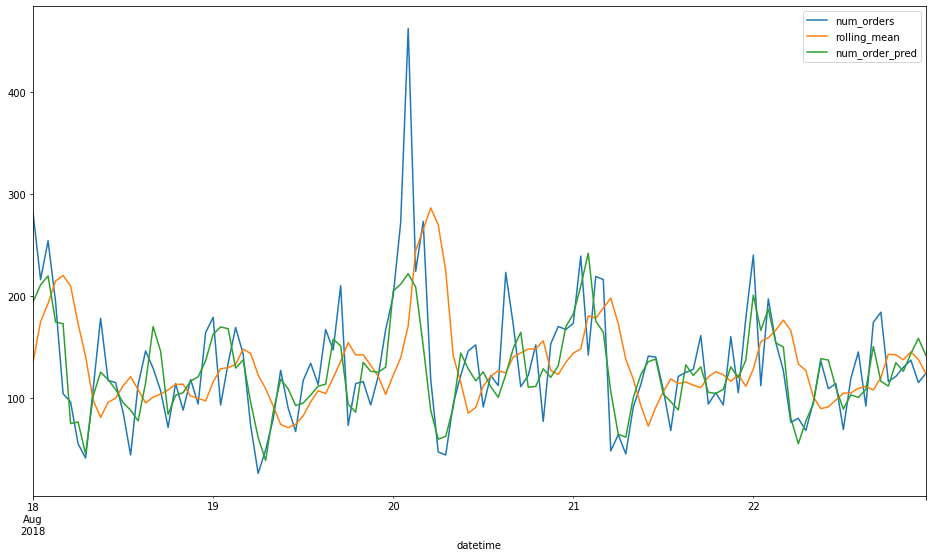

In [ ]:
test1 = test.drop(['year', 'month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8','lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17','lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23','lag_24',], axis=1)
test1['2018-08-18':'2018-08-22'].plot(figsize=(16,9))

**Вывод**
- Лучшее качество показал модель - LGBMRegressor;
- Качество моделей очень сильно зависит от выбранного сдвига, и не так сильно от скользящей средней;
- Учитывая сдвиг в 24 часа, чтобы предсказать данные на следующий час, у нас должны быть данные минимум за 48 часов;
- На графике мы видим, как наша модель предсказывает кол-во вызовов такси, она не чувствительна к большим пикам, т.к. на обучающей выборке их было немного, а в авгусе много, поэтому отличие RMSE теста хуже, чем на валидации.